In [ ]:
import pandas as pd

# Convertir les recommandations en DataFrame
reco_data = {
    'PME': [pme['Nom'] for pme in recommandations],
    'Type': [pme['Type'] for pme in recommandations],
    'Similitude': [pme['similarity'] for pme in recommandations],
    'NoteMoyenne': [pme['NoteMoyenne'] for pme in recommandations]
}

df_recommendations = pd.DataFrame(reco_data)
display(df_recommendations)


In [ ]:
import folium

# Initialiser la carte centrée sur la localisation moyenne des PME
map_center = [4.044, 9.709]  # Par exemple, Cameroun
map_pme = folium.Map(location=map_center, zoom_start=7)

# Ajouter des marqueurs pour les PME recommandées
for pme in recommandations:
    folium.Marker(
        location=pme['LocalisationGps'], 
        popup=f"{pme['Nom']} - Similitude: {pme['similarity']:.2f}",
        icon=folium.Icon(color='blue' if pme['Type'] == 'Collaborateur' else 'red')
    ).add_to(map_pme)

map_pme


In [ ]:
# Affichage des collaborateurs
collaborators = df_recommendations[df_recommendations['Type'] == 'Collaborateur']
display(collaborators)

# Affichage des concurrents
competitors = df_recommendations[df_recommendations['Type'] == 'Concurrent']
display(competitors)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histogramme des Notes Moyennes
plt.figure(figsize=(10,6))
sns.histplot(df_recommendations['NoteMoyenne'], bins=5, kde=True)
plt.title('Distribution des Notes Moyennes')
plt.xlabel('Note Moyenne')
plt.ylabel('Nombre de PME')
plt.show()


In [2]:
import seaborn as sns
import pandas as pd
# Calculer une matrice de similarité
similarity_matrix = pd.pivot_table(df_recommendations, values='Similitude', index='PME', columns='PME')

# Afficher la heatmap
plt.figure(figsize=(12,8))
sns.heatmap(similarity_matrix, annot=True, cmap="YlGnBu")
plt.title('Matrice de Similarité des PME')
plt.show()


NameError: name 'df_recommendations' is not defined

In [ ]:
# Exporter les résultats
df_recommendations.to_csv('resultats_recommandation.csv', index=False)


In [20]:
import random
from pymongo import MongoClient
from datetime import datetime, timedelta

# Connexion à la base de données MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["SMEdb"]
collection = db["pmes"]

# Liste des types d'abonnements et leur durée en jours (exemple : Gratuit n'a pas de fin, Premium dure 30 jours, VIP 365 jours)
abonnements = [
    {"type": "Gratuit", "duree": None},
    {"type": "Premium", "duree": 30},
    {"type": "VIP", "duree": 365}
]

# Fonction pour générer une date de fin d'abonnement
def generate_date_fin(abonnement_type):
    if abonnement_type["duree"]:
        return datetime.now() + timedelta(days=abonnement_type["duree"])
    return None  # Pas de date de fin pour "Gratuit"

# Fonction pour attribuer aléatoirement des abonnements aux PME
def assign_random_abonnements():
    pmes = collection.find()
    
    for pme in pmes:
        # Sélectionner un abonnement aléatoire
        abonnement = random.choice(abonnements)
        
        # Construire le champ Abonnement à mettre à jour
        abonnement_data = {
            "Abonnement.type": abonnement["type"],
            "Abonnement.DateDebut": datetime.now(),
            "Abonnement.DateFin": generate_date_fin(abonnement),
            "Abonnement.Actif": True
        }
        
        # Mettre à jour la PME avec l'abonnement choisi
        collection.update_one(
            {"_id": pme["_id"]},
            {"$set": abonnement_data}
        )
        print(f"Abonnement {abonnement['type']} attribué à la PME {pme['Nom']}.")

# Exécuter la fonction
assign_random_abonnements()


Abonnement Premium attribué à la PME Nisi Dictum LLP.
Abonnement Gratuit attribué à la PME At Iaculis Incorporated.
Abonnement Premium attribué à la PME Nunc Sed Corp..
Abonnement VIP attribué à la PME Convallis Ante Consulting.
Abonnement Premium attribué à la PME Semper Pretium Consulting.
Abonnement Gratuit attribué à la PME Mollis Dui In Industries.
Abonnement Premium attribué à la PME Proin Ultrices Ltd.
Abonnement Premium attribué à la PME Arcu Aliquam PC.
Abonnement VIP attribué à la PME Faucibus Leo In Limited.
Abonnement VIP attribué à la PME Molestie Inc..
Abonnement VIP attribué à la PME Lorem Ac Associates.
Abonnement Gratuit attribué à la PME At Auctor Inc..
Abonnement Gratuit attribué à la PME In Aliquet Corp..
Abonnement VIP attribué à la PME Nascetur Ridiculus LLP.
Abonnement VIP attribué à la PME Proin Dolor Foundation.
Abonnement Premium attribué à la PME Tellus Imperdiet Industries.
Abonnement VIP attribué à la PME Luctus Et Incorporated.
Abonnement Gratuit attribué 

In [9]:
import json
from bson import ObjectId
from recommandation_engine import get_recommendations

# Fonction pour générer un fichier JSON à partir des recommandations
def generate_recommendations_json(pme_id, output_file='recommandations.json'):
    recommendations = get_recommendations(pme_id)
    
    # Préparer les données pour le fichier JSON
    reco_data = [{
        'PME': rec['pme']['Nom'],
        'Type': rec['pme']['Type'],
        'Activites': rec['pme'].get('Activites', []),
        'Langues': rec['pme'].get('Langues', []),
        'Effectif': rec['pme'].get('Effectif', None),
        'ChiffreAffaire': rec['pme'].get('ChiffreAffaire', None),
        'LocalisationGps': rec['pme'].get('LocalisationGps', []),
        'NoteMoyenne': rec['pme'].get('NoteMoyenne', 0),
        'NombreDeVotes': rec['pme'].get('NombreDeVotes', 0),
        'Abonnement': rec['pme']['Abonnement']['type'] if 'Abonnement' in rec['pme'] else 'Gratuit',
        'Similarité': rec['similarity']
    } for rec in recommendations]
    
    # Sauvegarder dans un fichier JSON
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(reco_data, f, ensure_ascii=False, indent=4)
    
    print(f"Le fichier {output_file} a été généré avec succès.")


# Exemple d'utilisation avec un ObjectId valide
generate_recommendations_json('66c361d3c177717a96dd2e7a')  # Remplacez 'votre_pme_id' par un ObjectId valide


ImportError: cannot import name 'SON' from 'bson' (c:\Users\stagiaire\AppData\Local\Programs\Python\Python312\Lib\site-packages\bson\__init__.py)

In [ ]:
import matplotlib.pyplot as plt

def plot_concurrents_potentiels(recommendations, pme_id):
    concurrents = [rec for rec in recommendations if rec['similarity'] > 0.7 and rec['pme']['Type'] == 'Fournisseur']
    
    noms = [rec['pme']['Nom'] for rec in concurrents]
    similitudes = [rec['similarity'] for rec in concurrents]
    
    plt.figure(figsize=(10, 6))
    plt.barh(noms, similitudes, color='red')
    plt.xlabel('Taux de similarité')
    plt.ylabel('Concurrents potentiels')
    plt.title(f"Concurrents potentiels pour la PME ID: {pme_id}")
    plt.show()

# Obtenir les recommandations et les visualiser
recommendations = get_recommendations(pme_id='66c361d3c177717a96dd2e7a')
plot_concurrents_potentiels(recommendations, pme_id='66c361d3c177717a96dd2e7a')


In [3]:
def plot_collaborateurs_potentiels(recommendations, pme_id):
    collaborateurs = [rec for rec in recommendations if rec['similarity'] > 0.5 and rec['similarity'] <= 0.7 and rec['pme']['Type'] != 'Fournisseur']
    
    noms = [rec['pme']['Nom'] for rec in collaborateurs]
    similitudes = [rec['similarity'] for rec in collaborateurs]
    
    plt.figure(figsize=(10, 6))
    plt.barh(noms, similitudes, color='green')
    plt.xlabel('Taux de similarité')
    plt.ylabel('Collaborateurs potentiels')
    plt.title(f"Collaborateurs potentiels pour la PME ID: {pme_id}")
    plt.show()

# Visualiser les collaborateurs potentiels
plot_collaborateurs_potentiels(recommendations, pme_id='66c361d3c177717a96dd2e7a')


NameError: name 'recommendations' is not defined

In [73]:
def plot_investisseurs_fournisseurs_stats(pmes):
    # Compter les investisseurs et fournisseurs
    investors = len([pme for pme in pmes if pme['Type'] == 'Investisseurs'])
    suppliers = len([pme for pme in pmes if pme['Type'] == 'Fournisseur'])

    # Afficher un graphique en barres
    plt.figure(figsize=(8, 6))
    plt.bar(['Investisseurs', 'Fournisseurs'], [investors, suppliers], color=['blue', 'green'])
    plt.title("Nombre d'Investisseurs et de Fournisseurs")
    plt.xlabel('Type de PME')
    plt.ylabel('Nombre')
    plt.show()

# Exemple d'utilisation
plot_investisseurs_fournisseurs_stats(recommendations)  # Assurez-vous que 'pmes' est une liste de vos PME


KeyError: 'Type'

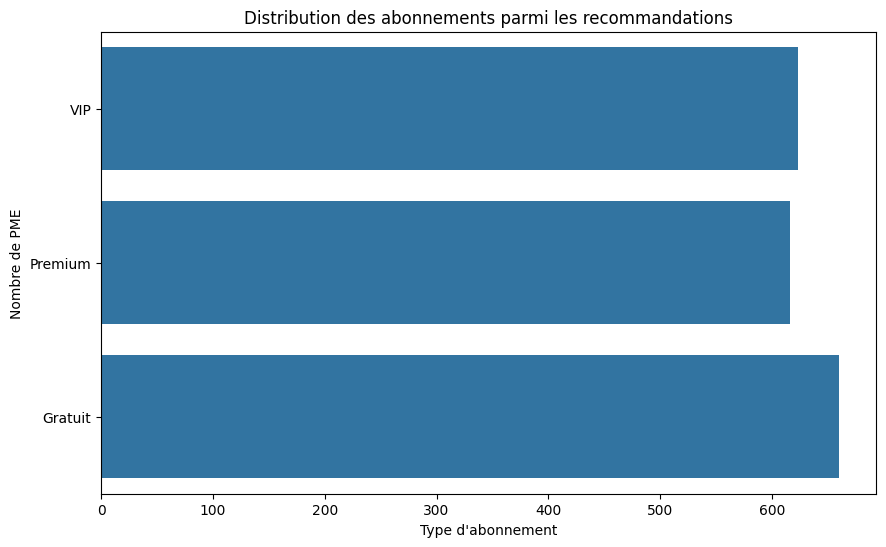

In [50]:
def plot_abonnement_impact(recommendations):
    types_abonnement = [rec['pme']['Abonnement']['type'] for rec in recommendations]
    
    plt.figure(figsize=(10, 6))
    sns.countplot(types_abonnement)
    plt.title("Distribution des abonnements parmi les recommandations")
    plt.xlabel("Type d'abonnement")
    plt.ylabel("Nombre de PME")
    plt.show()

# Visualiser l'impact des abonnements sur les recommandations
plot_abonnement_impact(recommendations)


In [20]:

import folium
from bson import ObjectId
from recommandation_engine import get_recommendations
from models.pme_model import pme_model  # Assurez-vous d'importer votre modèle PME

def plot_collaborators_and_competitors(pme_id):
    # Convertir pme_id en ObjectId
    try:
        pme_object_id = ObjectId(pme_id)
    except Exception as e:
        raise ValueError(f"L'ID fourni ({pme_id}) n'est pas un ObjectId valide.")

    # Récupérer la PME courante depuis la base de données
    current_pme = pme_model.find_by_id(pme_object_id)
    if not current_pme:
        raise ValueError(f"PME avec l'ID {pme_id} non trouvée dans la base de données.")

    # Obtenir les recommandations
    recommendations = get_recommendations(pme_id)

    # Séparer les concurrents et collaborateurs
    competitors = [rec['pme'] for rec in recommendations if rec['similarity'] > 0.7][:10]
    collaborators = [rec['pme'] for rec in recommendations if 0.5 < rec['similarity'] <= 0.7][:10]

    # Vérifier la présence de LocalisationGps pour la PME courante
    if 'LocalisationGps' not in current_pme or len(current_pme['LocalisationGps']) != 2:
        raise ValueError(f"La PME courante avec l'ID {pme_id} n'a pas de 'LocalisationGps' valide.")

    # Initialiser la carte
    map_center = [current_pme['LocalisationGps'][0], current_pme['LocalisationGps'][1]]
    pme_map = folium.Map(location=map_center, zoom_start=6)

    # Ajouter la PME courante en bleu
    folium.Marker(
        location=current_pme['LocalisationGps'],
        popup=current_pme['Nom'],
        icon=folium.Icon(color='blue', icon='home', icon_anchor=(0, 20))
    ).add_to(pme_map)

    # Ajouter les concurrents en rouge "<b>Nom :</b> " + Competitor['Nom'] + "<br>" + "<b>Type :</b> " + Competitor['Type']
    for competitor in competitors:
        if 'LocalisationGps' in competitor and len(competitor['LocalisationGps']) == 2:
            folium.Marker(
                location=competitor['LocalisationGps'],
                popup="<b>Nom :</b> " + competitor['Nom'] + "<br>" + "<b>Type :</b> " + competitor['Type'],
                icon=folium.Icon(color='red', icon='flag')
            ).add_to(pme_map)

    # Ajouter les collaborateurs en vert
    for collaborator in collaborators:
        if 'LocalisationGps' in collaborator and len(collaborator['LocalisationGps']) == 2:
            folium.Marker(
                location=collaborator['LocalisationGps'],
                popup="<b>Nom :</b> " + collaborator['Nom'] + "<br>" + "<b>Type :</b> " + collaborator['Type'],
                icon=folium.Icon(color='green', icon='icon-thumbs-up-alt')
            ).add_to(pme_map)

    # Afficher la carte
    return pme_map

# Exemple d'utilisation avec un ObjectId valide
pme_map = plot_collaborators_and_competitors('66c361d3c177717a96dd2e7a')  # Remplacez par un ObjectId valide
pme_map.save('pme_recommendations_map.html')


ImportError: cannot import name 'SON' from 'bson' (c:\Users\stagiaire\AppData\Local\Programs\Python\Python312\Lib\site-packages\bson\__init__.py)